In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np


import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import time
import json
import pickle
from preprocessing_dailydialogue import *

In [2]:
# Define constant
# Default word tokens
#
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
MAX_LENGTH = 10  # Maximum sentence length to consider
MIN_COUNT = 1   # Minimum word count threshold for trimming
save_dir = os.path.join("data", "save")
emo_dict = { 0: 'neutral', 1: 'joy', 2: 'anger', 
            3: 'sadness',4:'fear'}
emo2idx = {value:key for key,value in emo_dict.items()}


# Read Data and preprocess

In [3]:
with open('processed_train.pickle','rb') as f:
    pairs = pickle.load(f)
    pairs_emotion = pickle.load(f)
    voc = pickle.load(f)

# Convert data to tensor
dimensions is shown in the following
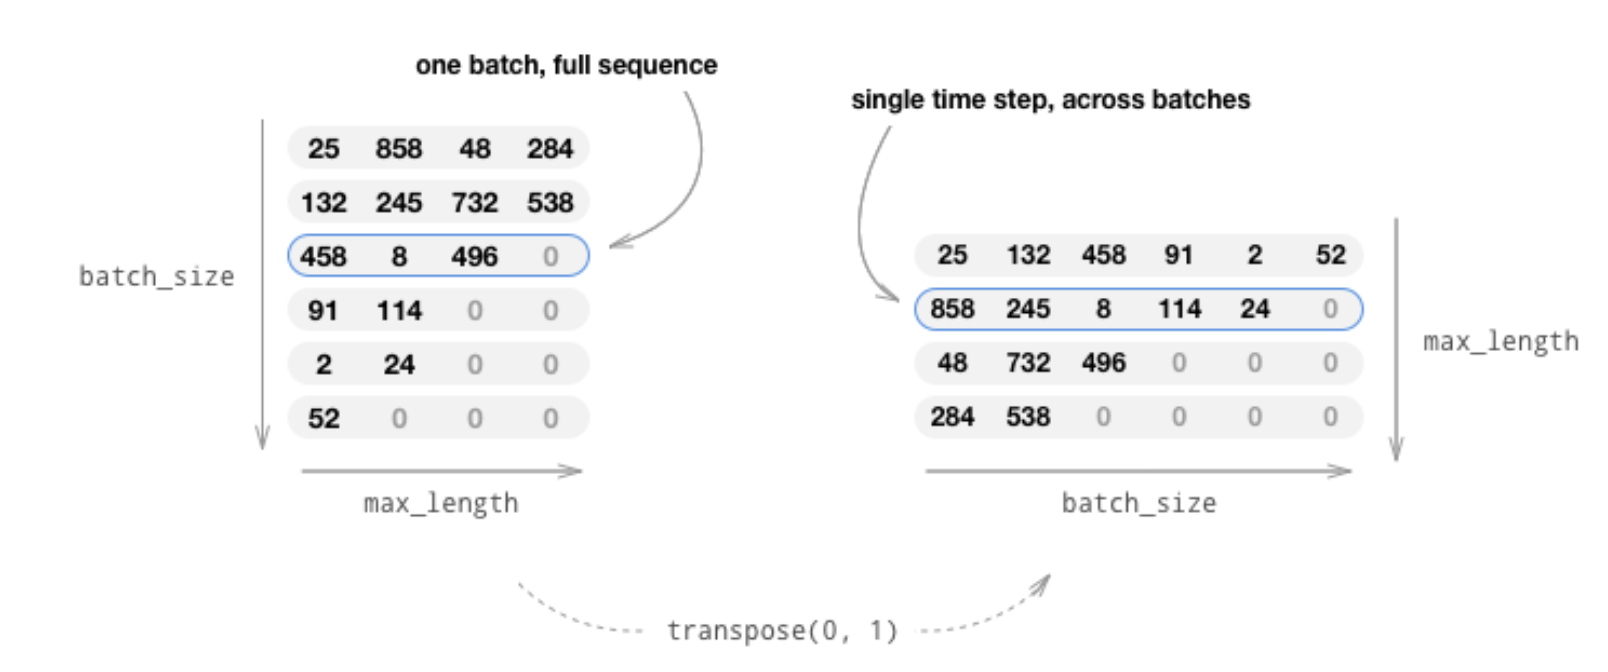

In [4]:
# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(list(range(len(pairs)))) for _ in range(small_batch_size)],pairs,pairs_emotion)
input_variable,input_emotion, lengths, target_variable,target_emotion, mask, max_target_len = batches

print("input_variable:", input_variable)
print('Input_emotion:',input_emotion)
print("lengths:", lengths)
print("target_variable:", target_variable)
print('target_emotion:',target_emotion)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  151,   111,   366,    30, 13408],
        [    8,    16,    31,     8,    13],
        [  342,  1811,   366,   689,     2],
        [  212,  3121,   473,    13,     0],
        [  336,     6,     6,     2,     0],
        [11664,     2,     2,     0,     0],
        [12301,     0,     0,     0,     0],
        [    6,     0,     0,     0,     0],
        [    2,     0,     0,     0,     0]])
Input_emotion: tensor([2, 2, 0, 4, 4])
lengths: tensor([9, 6, 6, 5, 3])
target_variable: tensor([[ 212, 3121,   11,   39,   11],
        [   6,   59,  131,  812,   88],
        [   2,    2,   35,   65,   19],
        [   0,    0, 3211,   38,   47],
        [   0,    0,   76,   15,   13],
        [   0,    0,    8, 1231,    2],
        [   0,    0,   24,    6,    0],
        [   0,    0,   13,    2,    0],
        [   0,    0,    2,    0,    0]])
target_emotion: tensor([1, 3, 0, 2, 2])
mask: tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
       

# Encoder + Attention

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)    

# ECM: Internal memory

In [6]:
class ECMWrapper(nn.Module):
    def __init__(self,hidden_size,state_size,emo_size,num_emotion,embedding,emotion_embedding,gru):
        '''
        hidden_size: hidden input dimension
        state_size: state vector size
        emo_size: emotional embedding size
        num_emotion: number of emotion categories
        '''
        super(ECMWrapper,self).__init__()
        self.hidden_size = hidden_size
        self.state_size = state_size
        self.emo_size = emo_size
        self.num_emotion = num_emotion
        # read gate dimensions (word_embedding + hidden_input + context_input)
        self.read_g = nn.Linear(self.hidden_size + self.hidden_size + self.hidden_size,self.emo_size)
        # write gate
        self.write_g = nn.Linear(self.state_size, self.emo_size)
        # GRU output input dimensions = state_last + context + emotion emb + internal memory
        self.gru = gru
        self.emotion_embedding = emotion_embedding
        self.embedding = embedding
    def forward(self,word_input,emotion_input,last_hidden,context_input,M_emo):
        '''
        Last hidden == prev_cell_state
        last word embedding = word_input
        last hidden input = h
        '''
        # get embedding of input word and emotion
        context_input = context_input.unsqueeze(dim = 0)
        emo_embedding = self.emotion_embedding(emotion_input)
        emo_embedding = emo_embedding.unsqueeze(dim = 0)
        last_word_embedding = self.embedding(word_input)
        # sum bidirectional hidden input
        last_hidden_sum = torch.sum(last_hidden,dim = 0).unsqueeze(dim=0)
        read_inputs = torch.cat((last_word_embedding,last_hidden_sum,context_input), dim = -1)
        # compute read input
        read_inputs = self.read_g(read_inputs)
        M_read = torch.sigmoid(read_inputs)
        # write to emotion embedding
        emo_embedding = emo_embedding * M_read
        # pass everything to GRU
        X = torch.cat([last_word_embedding,last_hidden_sum, context_input, emo_embedding], dim = -1)
        rnn_output, hidden = self.gru(X,last_hidden)
        # write input
        M_write = torch.sigmoid(self.write_g(rnn_output))
        # write to emotion embedding
        new_M_emo = emo_embedding * M_write
        return rnn_output, hidden, new_M_emo
    

# Decoder part

In [7]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding,emotion_embedding, hidden_size, output_size, n_layers=1, dropout=0.1,num_emotions = 7):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.num_emotions = num_emotions
        # Define layers
        self.embedding = embedding
        # define emotion embedding
        self.emotion_embedding = emotion_embedding
        self.embedding_dropout = nn.Dropout(dropout)
        #self.emotion_embedding_dropout = nn.Dropout(dropout)
        # dimension
        self.gru = nn.GRU(hidden_size + hidden_size + hidden_size + hidden_size , hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)
        self.internal_memory = ECMWrapper(hidden_size,hidden_size,
                                          hidden_size,self.num_emotions,
                                          self.embedding,self.emotion_embedding,self.gru)
    def forward(self, input_step,input_step_emotion, last_hidden
                ,input_context, last_int_memory,encoder_outputs):
        '''
        First input_context will be a random vectors
        '''
        rnn_output, hidden, new_M_emo = self.internal_memory(input_step,input_step_emotion,
                                                            last_hidden,input_context,
                                                             last_int_memory)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden, new_M_emo, context

# NLL Loss + Internal Memory Loss

In [8]:
def maskNLLLoss_IMemory(inp, target, mask,M_emo):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).sum() + torch.norm(M_emo)
    loss = loss.to(device)
    return loss, nTotal.item()

# Single Train

In [9]:
def train(input_variable, lengths, target_variable,target_variable_emotion,
          mask, max_target_len, encoder, decoder, embedding,emotion_embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    target_variable_emotion = target_variable_emotion.to(device)
    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    
    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    # Set initial context value,last_rnn_output, internal_memory
    context_input = torch.FloatTensor(batch_size,hidden_size)
    context_input = context_input.to(device)
    # last_rnn_output = torch.FloatTensor(hidden_size)
    internal_memory = torch.randn(batch_size,hidden_size,dtype=torch.float)
    internal_memory = internal_memory.to(device)
    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden,internal_memory,context_input = decoder(
                decoder_input,target_variable_emotion, decoder_hidden,
                context_input, internal_memory,encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss_IMemory(decoder_output, target_variable[t], mask[t],internal_memory)
            loss += mask_loss
            print_losses.append(mask_loss.item()) # print average loss
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden,internal_memory,context_input = decoder(
                decoder_input,target_variable_emotion, decoder_hidden,
                context_input, internal_memory,encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss_IMemory(decoder_output, target_variable[t], mask[t],internal_memory)
            loss += mask_loss
            print_losses.append(mask_loss.item()) # print average loss
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

# Train Iteration

In [10]:
def trainIters(model_name, voc, pairs,pairs_emotion, 
               encoder, decoder, encoder_optimizer,
               decoder_optimizer, embedding,emotion_embedding, 
               encoder_n_layers, decoder_n_layers, save_dir, 
               n_iteration, batch_size, print_every, save_every, 
               clip,corpus_name):
    loadFilename=None
    # Load batches for each iteration
    #training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      #for _ in range(n_iteration)]
    print('Loading Training data ...')
    training_batches = [batch2TrainData(voc, [random.choice(list(range(len(pairs)))) for _ in range(batch_size)],
                                       pairs,pairs_emotion) for _ in range(n_iteration)]
    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable,input_variable_emotion, lengths, target_variable,target_variable_emotion, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable,target_variable_emotion,
                     mask, max_target_len, encoder,
                     decoder, embedding,emotion_embedding,
                     encoder_optimizer, decoder_optimizer, 
                     batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0 or iteration == 1:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

# Greedy Search

In [11]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder,num_word = None):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq,target_emotions,input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Set initial context value,last_rnn_output, internal_memory
        context_input = torch.FloatTensor(1,hidden_size)
        context_input = context_input.to(device)
        # last_rnn_output = torch.FloatTensor(hidden_size)
        internal_memory = torch.FloatTensor(batch_size,hidden_size)
        internal_memory = internal_memory.to(device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden,internal_memory,context_input = decoder(
                decoder_input,target_emotions, decoder_hidden,
                context_input, internal_memory,encoder_outputs
            )
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

# Beam Search

In [12]:
class BeamSearchDecoder(nn.Module):
    def __init__(self, encoder, decoder,num_word):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.num_word = num_word

    def forward(self, input_seq,target_emotions,input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_words_order = torch.zeros((1,self.num_word),device=device,dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        all_scores_array = torch.zeros((1,self.num_word),device=device,dtype=torch.float)
        # Set initial context value,last_rnn_output, internal_memory
        context_input = torch.FloatTensor(1,hidden_size)
        context_input = context_input.to(device)
        # last_rnn_output = torch.FloatTensor(hidden_size)
        internal_memory = torch.FloatTensor(batch_size,hidden_size)
        internal_memory = internal_memory.to(device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden,internal_memory,context_input = decoder(
                decoder_input,target_emotions, decoder_hidden,
                context_input, internal_memory,encoder_outputs
            )
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            decoder_input_order = torch.argsort(decoder_output,dim=1,descending=True)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            all_scores_array = torch.cat((all_scores_array,decoder_output),dim = 0)
            all_words_order = torch.cat((all_words_order,decoder_input_order), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        sequences = self.beam_search(all_scores_array,3)
        return sequences
    def beam_search(self,array,k):
        array = array.tolist()
        sequences = [[list(), 1.0]]
        # walk over each step in sequence
        for row in array:
            all_candidates = list()
            # expand each current candidate
            for i in range(len(sequences)):
                seq, score = sequences[i]
                for j in range(len(row)):
                    candidate = [seq + [j], score * -np.log(row[j] + 1e-8)]
                    all_candidates.append(candidate)
            # order all candidates by score
            ordered = sorted(all_candidates, key=lambda tup:tup[1])
            # select k best
            sequences = ordered[:k]
        return sequences

# Build Model

In [13]:
# Configure models
model_name = 'emotion_model'
corpus_name = 'dailydialogue'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
# number of emotion
num_emotions = 5

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 120
training = True
if loadFilename:
    training = False
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename,map_location='cpu')
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
emotion_embedding = nn.Embedding(num_emotions, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding,emotion_embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


# Run training

In [14]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 100
print_every = 1
save_every = 40


# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# Run training iterations
if training:
    print("Starting Training!")
    trainIters(model_name, voc, pairs,pairs_emotion, encoder, decoder, encoder_optimizer, decoder_optimizer,
               embedding,emotion_embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
               print_every, save_every, clip,corpus_name)

Building optimizers ...
Starting Training!
Loading Training data ...
Initializing ...
Training...
Iteration: 1; Percent complete: 1.0%; Average loss: 11.0272
Iteration: 2; Percent complete: 2.0%; Average loss: 10.7774
Iteration: 3; Percent complete: 3.0%; Average loss: nan
Iteration: 4; Percent complete: 4.0%; Average loss: nan
Iteration: 5; Percent complete: 5.0%; Average loss: nan
Iteration: 6; Percent complete: 6.0%; Average loss: nan
Iteration: 7; Percent complete: 7.0%; Average loss: nan
Iteration: 8; Percent complete: 8.0%; Average loss: nan
Iteration: 9; Percent complete: 9.0%; Average loss: nan
Iteration: 10; Percent complete: 10.0%; Average loss: nan
Iteration: 11; Percent complete: 11.0%; Average loss: nan
Iteration: 12; Percent complete: 12.0%; Average loss: nan
Iteration: 13; Percent complete: 13.0%; Average loss: nan
Iteration: 14; Percent complete: 14.0%; Average loss: nan
Iteration: 15; Percent complete: 15.0%; Average loss: nan
Iteration: 16; Percent complete: 16.0%; Av

# Evaluation

In [15]:
def evaluate(encoder, decoder, searcher, voc, sentence, emotions,max_length=MAX_LENGTH,beam_search = False):
    emotions = int(emotions)
    emotions = torch.LongTensor([emotions])
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    emotions = emotions.to(device)

    # indexes -> words
    if beam_search:
        sequences = searcher(input_batch, emotions, lengths, max_length)
        decoded_words = beam_decode(sequences,voc)
    else:
        # Decode sentence with searcher
        tokens, scores = searcher(input_batch, emotions, lengths, max_length)
        decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

def beam_decode(sequences,voc):
    for each in sequences:
        for idxs in each:
            return [voc.index2word[idx] for idx in idxs[:-1]]
    
def evaluateInput(encoder, decoder, searcher, voc,emotion_dict):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            for emotion in range(len(emotion_dict)):
                # Check if it is quit case
                if input_sentence == 'q' or input_sentence == 'quit': break
                # Normalize sentence
                input_sentence = normalizeString(input_sentence)
                # Evaluate sentence
                output_words = evaluate(encoder, decoder, searcher, voc, input_sentence,emotion,beam_search=True)
                # Format and print response sentence
                output=[]
                for word in output_words:
                    if word == 'PAD':
                        continue
                    elif word == 'EOS':
                        break
                    else:
                        output.append(word)
                # output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
                print('Bot({}):'.format(emotion_dict[emotion]), ' '.join(output))

        except KeyError:
            print("Error: Encountered unknown word.")
            

# Chat with bot

In [16]:
def toSentence(list_of_idx,voc):
    return ' '.join([voc.index2word[idx] for idx in list_of_idx])

In [17]:
# emotion dictionary
emo_dict = { 0: 'no emotion', 1: 'anger', 2: 'disgust', 
            3: 'fear', 4: 'happiness', 
            5: 'sadness', 6: 'surprise'}
# Set dropout layers to eval mode

encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)
searcher2 = BeamSearchDecoder(encoder,decoder,voc.num_words)
# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher2, voc,emo_dict)

> hi
Bot(no emotion): 
Bot(anger): 
Bot(disgust): 
Bot(fear): 
Bot(happiness): 


RuntimeError: CUDA error: device-side assert triggered